In [ ]:
%pip install scikit-learn 
%pip install pandas
%pip install optuna
%pip install xgboost
%pip install lightgbm
%pip install imbalanced-learn
%pip install matplotlib

In [64]:
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.feature_selection import mutual_info_classif
from sklearn.calibration import CalibratedClassifierCV

In [71]:
# Load the dataset and scale the 'Amount' column
data_df = pd.read_csv('./data.csv', index_col='id')
# Scale the amount since it was orders of magnitude different from the other features.
amount_scaler = StandardScaler()
features_scaler = StandardScaler()
data_df[['Amount']] = amount_scaler.fit_transform(data_df[['Amount']])
# Separate the features and target variable
y = data_df.Class
X = data_df.drop(['Class', 'Time'], axis=1)
X['V20*Amount'] = data_df['V20'] * data_df['Amount']
X['V5*V6'] = data_df['V5'] * data_df['V6']
X['V2/Amount'] = data_df['V2'] / data_df['Amount']
X['V9/V10'] = data_df['V9'] / data_df['V10']
X['V9/V10'] = np.where(np.isinf(X['V9/V10']), 1e10, X['V9/V10'])
X[['V20*Amount', 'V5*V6', 'V2/Amount', 'V9/V10']] = features_scaler.fit_transform(X[['V20*Amount', 'V5*V6', 'V2/Amount', 'V9/V10']])

LGBM Classifier ROC with CV: 0.8190919432148682


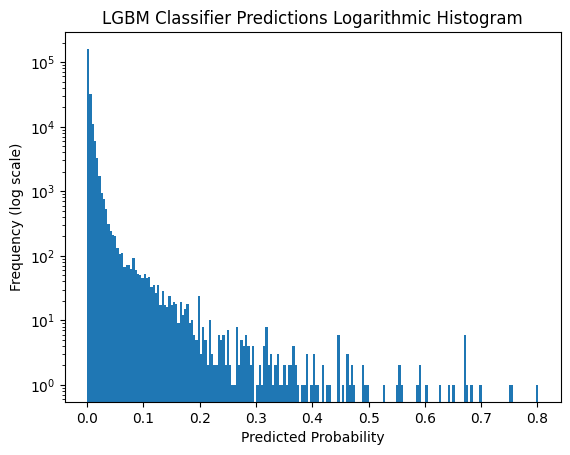

LogReg Classifier ROC with CV: 0.8001855394862277


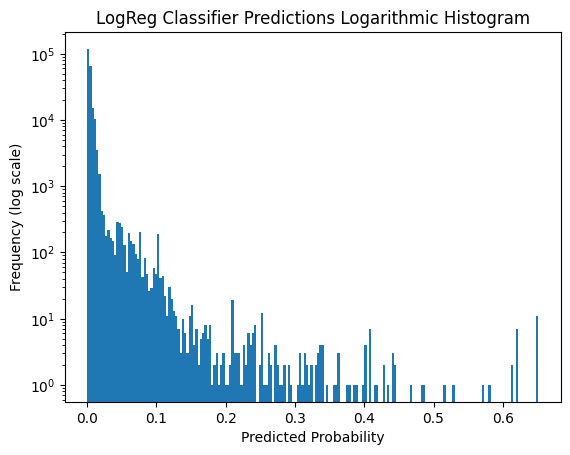

In [72]:
models = {
    'LGBM Classifier': LGBMClassifier(n_estimators=250, max_depth=4, learning_rate=0.01, num_leaves=100, min_child_samples=35, n_jobs=2),
    'LogReg Classifier': LogisticRegression(max_iter=1000, C=0.01, n_jobs=2)
}

for model_name, model in models.items():
    calibrated_model = CalibratedClassifierCV(model, method='isotonic', cv=5)
    pipeline = make_pipeline_imb(SMOTE(sampling_strategy=0.005, random_state=42), calibrated_model)
    cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='roc_auc')
    cv_predictions = cross_val_predict(pipeline, X, y, cv=5, method='predict_proba')[:, 1]
    cv_auc_roc = np.mean(cv_scores)
    print(f"{model_name} ROC with CV: {cv_auc_roc}")

    # Plot the logarithmic histogram
    plt.figure()
    plt.hist(cv_predictions, bins=200, log=True)
    plt.title(f"{model_name} Predictions Logarithmic Histogram")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Frequency (log scale)")
    plt.show()

Loading in the Test data and predicting with our best model (Doing the same kind of transformations and things we did to the training data): 

In [73]:
test_df = pd.read_csv('./test.csv', index_col='id')

# Scale the 'Amount' column
test_df[['Amount']] = amount_scaler.transform(test_df[['Amount']])

test_df['V20*Amount'] = test_df['V20'] * test_df['Amount']
test_df['V5*V6'] = test_df['V5'] * test_df['V6']
test_df['V2/Amount'] = test_df['V2'] / test_df['Amount']
test_df['V9/V10'] = test_df['V9'] / test_df['V10']
test_df['V9/V10'] = np.where(np.isinf(test_df['V9/V10']), 1e10, test_df['V9/V10'])

# Scale the engineered features
test_df[['V20*Amount', 'V5*V6', 'V2/Amount', 'V9/V10']] = features_scaler.transform(test_df[['V20*Amount', 'V5*V6', 'V2/Amount', 'V9/V10']])

test_df = test_df.drop(['Time'], axis=1)

In [80]:
lgbm_model = LGBMClassifier(n_estimators=400, max_depth=4, learning_rate=0.007, num_leaves=80, min_child_samples=35, n_jobs=2)
calibrated_lgbm = CalibratedClassifierCV(lgbm_model, method='isotonic', cv=4)
smote_pipeline = make_pipeline_imb(SMOTE(sampling_strategy=0.003, random_state=42), calibrated_lgbm)

smote_pipeline.fit(X, y)
test_predictions = smote_pipeline.predict_proba(test_df)[:, 1]

In [81]:
submission_df = pd.DataFrame({'id': test_df.index, 'Class': test_predictions})
submission_df.to_csv('submissionLGBM5.csv', index=False)

Code that was used while doing analysis and better the models:

In [ ]:
# Used to see if there was any high levels of MI between features and target.
mutual_information = mutual_info_classif(X, y)
# Create a dataframe to display the results
mi_df = pd.DataFrame({"Feature": X.columns, "Mutual Information": mutual_information})
mi_df.sort_values("Mutual Information", ascending=False, inplace=True)
print(mi_df)
# All very low MI. None seem very pertinent to the target on its own. So PCA dimensionality reduction useless, especially with only 30 features.

In [ ]:
# Used to see if we could feature engineer new features from highly correlated Pearson correlations
corr_matrix = X.corr(method='pearson')
# Set diagonal entries to NaN
corr_matrix_NaN = corr_matrix.where(~np.eye(corr_matrix.shape[0], dtype=bool))
# Get the top 10 positive and negative correlations
top_corr_pos = corr_matrix_NaN.unstack().sort_values(ascending=False).drop_duplicates()[:10]
top_corr_neg = corr_matrix_NaN.unstack().sort_values(ascending=True).drop_duplicates()[:10]

# Print the top positive and negative correlations and their locations
print("Top 10 positive correlations:")
print(top_corr_pos[top_corr_pos > 0])
print("\nTop 10 negative correlations:")
print(top_corr_neg[top_corr_neg < 0])

In [ ]:
# Used to tune hyperparameters of LGBM model
class LGBMObjective:
    def __init__(self, model, X, y):
        self.model = model
        self.X = X
        self.y = y
    
    def __call__(self, trial):
        # Define the search space for the hyperparameters
        n_estimators = trial.suggest_int('n_estimators', 100, 400)
        max_depth = trial.suggest_int('max_depth', 3, 6)
        learning_rate = trial.suggest_float('learning_rate', 0.005, 0.02, log=True)
        num_leaves = trial.suggest_int('num_leaves', 10, 200)
        min_child_samples = trial.suggest_int('min_child_samples', 10, 100)

        # Set the hyperparameters in the model
        self.model.set_params(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            num_leaves=num_leaves,
            min_child_samples=min_child_samples
        )

        # Calculate the mean AUC-ROC score using cross-validation
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        auc_roc_scores = cross_val_score(self.model, self.X, self.y, cv=cv, scoring='roc_auc', n_jobs=1)
        mean_auc_roc = auc_roc_scores.mean()

        return mean_auc_roc

lgbm = LGBMClassifier(n_jobs=2)
obj = LGBMObjective(lgbm, X, y)

# Create the Optuna study and optimize the hyperparameters
study = optuna.create_study(direction='maximize')
study.optimize(obj, n_trials=30)

# Print the best hyperparameters
best_params = study.best_params
print(f"Best hyperparameters: {best_params}")

In [ ]:
# Used to tune hyperparameter of LogReg
class LogRegObjective:
    def __init__(self, model, X, y):
        self.model = model
        self.X = X
        self.y = y
    
    def __call__(self, trial):
        # Define the search space for the hyperparameters
        C = trial.suggest_float('C', 0.003, 0.06)

        # Set the hyperparameters in the model
        self.model.set_params(
            C=C,
        )

        # Calculate the mean AUC-ROC score using cross-validation
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        auc_roc_scores = cross_val_score(self.model, self.X, self.y, cv=cv, scoring='roc_auc', n_jobs=1)
        mean_auc_roc = auc_roc_scores.mean()

        return mean_auc_roc

logreg = LogisticRegression(max_iter=1000, n_jobs=2)
obj_logreg = LogRegObjective(logreg, X, y)

# Create the Optuna study and optimize the hyperparameters
study_logreg = optuna.create_study(direction='maximize')
study_logreg.optimize(obj_logreg, n_trials=30)

# Print the best hyperparameters
best_params_logreg = study_logreg.best_params
print(f"Best hyperparameters for Logistic Regression: {best_params_logreg}")